Training agent with Q-learning...
Episode 1/2000  reward=2.400  eps=0.995
Episode 201/2000  reward=2.480  eps=0.365
Episode 401/2000  reward=4.500  eps=0.134
Episode 601/2000  reward=2.640  eps=0.050
Episode 801/2000  reward=5.000  eps=0.050
Episode 1001/2000  reward=1.680  eps=0.050
Episode 1201/2000  reward=4.560  eps=0.050
Episode 1401/2000  reward=3.920  eps=0.050
Episode 1601/2000  reward=3.800  eps=0.050
Episode 1801/2000  reward=6.300  eps=0.050


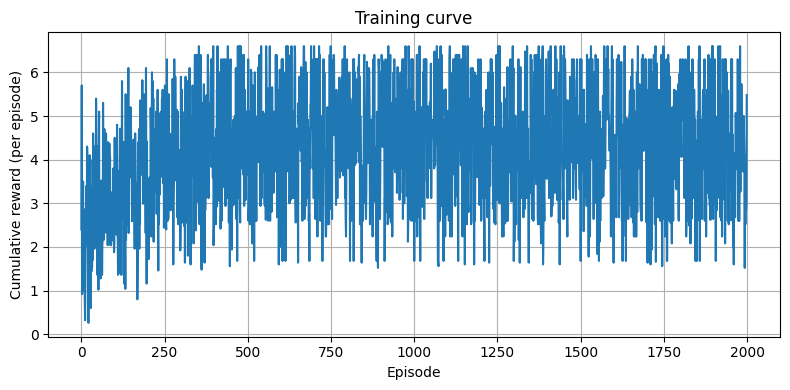


Evaluation (greedy policy) mean reward: 4.511 ± 1.296
Saved Q-table to q_table.pkl

Sample recommendations (top 3) for user profiles:
  Unfit_poor_adherence_weight_loss: state=(0, 0, 0)
    mixed + high_protein            Q=5.419
    strength + low_calorie          Q=1.040
    cardio + low_calorie            Q=0.552

  Moderate_avg_adherence_muscle_gain: state=(2, 1, 1)
    rest_light + balanced           Q=7.489
    cardio + balanced               Q=0.803
    strength + low_calorie          Q=0.788

  Fit_high_adherence_maintain: state=(4, 2, 2)
    mixed + balanced                Q=5.980
    rest_light + balanced           Q=5.443
    cardio + balanced               Q=5.203



In [3]:
import numpy as np
import random
import pickle
import os
import matplotlib.pyplot as plt

# fitness_level: 0-4  (0: very unfit, 4: fit)
# adherence_level: 0-2 (0: poor, 1: average, 2: high) — encapsulates user's compliance tendency
# goal: 0-2  (0: weight_loss, 1: muscle_gain, 2: maintain)
N_FITNESS = 5
N_ADHERENCE = 3
N_GOALS = 3

def state_to_index(fitness, adherence, goal):
    return (fitness * N_ADHERENCE * N_GOALS) + (adherence * N_GOALS) + goal

def index_to_state(idx):
    goal = idx % N_GOALS
    adherence = (idx // N_GOALS) % N_ADHERENCE
    fitness = idx // (N_ADHERENCE * N_GOALS)
    return fitness, adherence, goal

N_STATES = N_FITNESS * N_ADHERENCE * N_GOALS

# workout_type: 0-3 -> {0: rest/light, 1: cardio, 2: strength, 3: mixed}
# diet_type: 0-2 -> {0: balanced, 1: high-protein, 2: low-calorie}
WORKOUTS = ["rest_light", "cardio", "strength", "mixed"]
DIETS = ["balanced", "high_protein", "low_calorie"]
N_WORKOUTS = len(WORKOUTS)
N_DIETS = len(DIETS)
ACTIONS = [(w, d) for w in range(N_WORKOUTS) for d in range(N_DIETS)]
N_ACTIONS = len(ACTIONS)

def action_to_label(a):
    w, d = ACTIONS[a]
    return f"{WORKOUTS[w]} + {DIETS[d]}"


class FitnessEnv:

    def __init__(self, seed=None):
        self.rng = random.Random(seed)
        self.np_rng = np.random.RandomState(seed)
        self.reset()

    def reset(self, user_profile=None):
        if user_profile is None:
            fitness = self.rng.choice(range(N_FITNESS))
            adherence = self.rng.choice(range(N_ADHERENCE))
            goal = self.rng.choice(range(N_GOALS))
        else:
            fitness, adherence, goal = user_profile
        self.state = (fitness, adherence, goal)
        return state_to_index(*self.state)

    def step(self, action):
        """
        Apply action for one 'week' (an episode step).
        Return new_state_idx, reward, done, info
        """
        fitness, adherence, goal = self.state
        w, d = ACTIONS[action]

        workout_effect = {
            0: -0.1,  # rest/light might lead to small decrease
            1: 0.2,   # cardio improves general fitness / weight loss
            2: 0.25,  # strength helps muscle gain
            3: 0.18   # mixed
        }[w]

        diet_goal_map = {
            0: {0: 0.1, 1: 0.05, 2: 0.2},  # goal weight_loss -> low_calorie (2) best
            1: {0: 0.05, 1: 0.2, 2: 0.0},  # goal muscle_gain -> high_protein (1) best
            2: {0: 0.15, 1: 0.1, 2: 0.05}  # goal maintain -> balanced (0) best
        }
        diet_alignment = diet_goal_map[goal][d]

        adherence_factor = {0: 0.4, 1: 0.7, 2: 1.0}[adherence]

        noise = self.np_rng.normal(loc=0.0, scale=0.05)

        delta = (workout_effect + diet_alignment) * adherence_factor + noise

        if not hasattr(self, 'fitness_internal'):
            self.fitness_internal = float(fitness)
        self.fitness_internal = max(0.0, min(4.0, self.fitness_internal + delta))

        new_fitness = int(round(self.fitness_internal))
        new_fitness = max(0, min(4, new_fitness))

        adherence_change_prob = 0.05 + 0.05 * (1 if w == 2 else 0)  # strength training may improve adherence a bit
        if self.np_rng.rand() < adherence_change_prob:

            if diet_alignment > 0.15 and workout_effect > 0.1:
                new_adherence = min(2, adherence + 1)
            else:
                new_adherence = max(0, adherence - 1) if self.np_rng.rand() < 0.02 else adherence
        else:
            new_adherence = adherence

        new_goal = goal

        new_state = (new_fitness, new_adherence, new_goal)
        self.state = new_state


        reward = 0.0
        if new_fitness > fitness:
            reward += 1.0
        elif new_fitness < fitness:
            reward -= 0.5

        reward += diet_alignment * adherence_factor * 2.0

        if goal == 1 and w == 0:
            reward -= 0.3

        reward = float(max(-2.0, min(3.0, reward)))

        done = False

        info = {"fitness_internal": self.fitness_internal}
        return state_to_index(*self.state), reward, done, info


class QLearningAgent:
    def __init__(self, n_states, n_actions, alpha=0.1, gamma=0.95, epsilon=1.0, min_epsilon=0.05, eps_decay=0.995):
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma

        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.eps_decay = eps_decay

        self.Q = np.zeros((n_states, n_actions), dtype=np.float32)

    def choose_action(self, state_idx):
        if random.random() < self.epsilon:
            return random.randrange(self.n_actions)
        else:
            return int(np.argmax(self.Q[state_idx]))

    def update(self, s, a, r, s_next):
        q_sa = self.Q[s, a]
        q_target = r + self.gamma * np.max(self.Q[s_next])
        self.Q[s, a] = q_sa + self.alpha * (q_target - q_sa)

    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.eps_decay)

    def save(self, path="q_table.pkl"):
        with open(path, "wb") as f:
            pickle.dump(self.Q, f)

    def load(self, path="q_table.pkl"):
        with open(path, "rb") as f:
            self.Q = pickle.load(f)


def train(agent, env, episodes=2000, max_steps_per_episode=20, verbose=True):
    """
    Train RL agent in the simulated fitness environment.
    Episodes are short (e.g., representing several weeks).
    Returns history of cumulative rewards per episode.
    """
    history = []
    for ep in range(episodes):
        s = env.reset()
        total_reward = 0.0
        for step in range(max_steps_per_episode):
            a = agent.choose_action(s)
            s_next, r, done, _ = env.step(a)
            agent.update(s, a, r, s_next)
            s = s_next
            total_reward += r

        agent.decay_epsilon()
        history.append(total_reward)
        if verbose and (ep % max(1, episodes // 10) == 0):
            print(f"Episode {ep+1}/{episodes}  reward={total_reward:.3f}  eps={agent.epsilon:.3f}")
    return history

def evaluate_policy(agent, env, episodes=200, max_steps=20):
    """
    Evaluate greedy policy (epsilon=0) average cumulative reward.
    """
    old_eps = agent.epsilon
    agent.epsilon = 0.0
    rewards = []
    for ep in range(episodes):
        s = env.reset()
        total = 0.0
        for _ in range(max_steps):
            a = agent.choose_action(s)
            s, r, done, _ = env.step(a)
            total += r
        rewards.append(total)
    agent.epsilon = old_eps
    return np.mean(rewards), np.std(rewards)


def recommend_for_user(agent, user_profile, top_k=3):
    """
    Given a user_profile (fitness, adherence, goal), return top_k recommended actions
    according to the learned Q table.
    """
    s_idx = state_to_index(*user_profile)
    qvals = agent.Q[s_idx]
    idxs = np.argsort(qvals)[::-1][:top_k]
    return [(i, action_to_label(i), qvals[i]) for i in idxs]


def demo_run():
    seed = 42
    env = FitnessEnv(seed=seed)
    agent = QLearningAgent(n_states=N_STATES, n_actions=N_ACTIONS, alpha=0.1, gamma=0.95,
                           epsilon=1.0, min_epsilon=0.05, eps_decay=0.995)
    print("Training agent with Q-learning...")
    history = train(agent, env, episodes=2000, max_steps_per_episode=14, verbose=True)

    try:
        plt.figure(figsize=(8,4))
        plt.plot(history, label="episode reward")
        plt.xlabel("Episode")
        plt.ylabel("Cumulative reward (per episode)")
        plt.title("Training curve")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception:
        print("Plotting failed (maybe running in non-GUI environment).")

    mean_r, std_r = evaluate_policy(agent, env, episodes=200, max_steps=14)
    print(f"\nEvaluation (greedy policy) mean reward: {mean_r:.3f} ± {std_r:.3f}")

    outpath = "q_table.pkl"
    agent.save(outpath)
    print(f"Saved Q-table to {outpath}")

    profiles = {
        "Unfit_poor_adherence_weight_loss": (0, 0, 0),
        "Moderate_avg_adherence_muscle_gain": (2, 1, 1),
        "Fit_high_adherence_maintain": (4, 2, 2)
    }
    print("\nSample recommendations (top 3) for user profiles:")
    for name, profile in profiles.items():
        recs = recommend_for_user(agent, profile, top_k=3)
        print(f"  {name}: state={profile}")
        for idx, label, q in recs:
            print(f"    {label:30s}  Q={q:.3f}")
        print()


def cli_demo_load_or_train(qpath="q_table.pkl"):

    env = FitnessEnv(seed=123)
    agent = QLearningAgent(n_states=N_STATES, n_actions=N_ACTIONS, alpha=0.1, gamma=0.95,
                           epsilon=1.0, min_epsilon=0.05, eps_decay=0.995)
    if os.path.exists(qpath):
        agent.load(qpath)
        print(f"Loaded Q-table from {qpath}")
    else:
        print("No saved Q-table found. Training now (this may take ~1-2 minutes)...")
        train(agent, env, episodes=1500, max_steps_per_episode=12, verbose=False)
        agent.save(qpath)
        print(f"Training done. Saved Q-table to {qpath}")

    print("\nEnter user profile (or press Enter to use default sample):")
    try:
        s_fitness = input("  fitness_level (0 very unfit .. 4 fit) [default 2]: ") or "2"
        s_adherence = input("  adherence (0 poor,1 avg,2 high) [default 1]: ") or "1"
        s_goal = input("  goal (0 weight_loss,1 muscle_gain,2 maintain) [default 0]: ") or "0"
        profile = (int(s_fitness), int(s_adherence), int(s_goal))
    except Exception:
        profile = (2, 1, 0)
    print(f"Profile: {profile}")
    recs = recommend_for_user(agent, profile, top_k=5)
    print("Top recommendations:")
    for idx, label, q in recs:
        print(f" - {label:30s}  Q-value={q:.3f}")

if __name__ == "__main__":
    # If run as script, do demo run (train + evaluate + recommendations).
    demo_run()
    # Uncomment the line below to enable CLI interactive demo after training
    # cli_demo_load_or_train("q_table.pkl")